In [9]:
from pathlib import Path
from collections import Counter
from PIL import Image
import pandas as pd

WSIROI_PATH = "data/wsirois/roi-level-annotations/tissue-cells/tissue-cells/"
paths = [path.parts[-2:] for path in Path(WSIROI_PATH).rglob('*.*')]

In [10]:
df = pd.DataFrame(data=paths, columns=['Class','Images'])
df.drop(df.index[0], inplace=True)
df = df.sort_values('Class',ascending=True)
df.reset_index(drop=True, inplace=True)

In [11]:
df

,Class,Images
0,images,"100B_[10779, 11621, 12102, 12874].png"
1,images,TCGA-E2-A1LH-01Z-00-DX1.F85384B7-1EBF-4F57-A45...
2,images,TCGA-E2-A1LH-01Z-00-DX1.F85384B7-1EBF-4F57-A45...
3,images,TCGA-E2-A1LH-01Z-00-DX1.F85384B7-1EBF-4F57-A45...
4,images,TCGA-E2-A1LH-01Z-00-DX1.F85384B7-1EBF-4F57-A45...
...,...,...
3753,masks,TCGA-AN-A0AT-01Z-00-DX1.DFD68CD2-C25E-47BE-BC0...
3754,masks,TCGA-AN-A0AT-01Z-00-DX1.DFD68CD2-C25E-47BE-BC0...
3755,masks,TCGA-AN-A0AT-01Z-00-DX1.DFD68CD2-C25E-47BE-BC0...
3756,masks,TCGA-AN-A0G0-01Z-00-DX1.BE0BB5DF-DEDA-48D8-B5D...


In [12]:
df.describe()

,Class,Images
count,3758,3758
unique,2,1879
top,images,TCGA-AN-A0AT-01Z-00-DX1.DFD68CD2-C25E-47BE-BC0...
freq,1879,2


In [13]:
df['Class'].value_counts()

Class
images    1879
masks     1879
Name: count, dtype: int64

In [14]:
directories = {
    "images": WSIROI_PATH + "images/",
    "masks": WSIROI_PATH + "masks/",
}


def get_dimensions_images(file):
    image = Image.open(file)
    arr = np.array(image)
    height, width, dims = arr.shape
    return height, width
    
def get_dimensions_masks(file):
    image = Image.open(file)
    arr = np.array(image)
    height, width = arr.shape
    return height, width

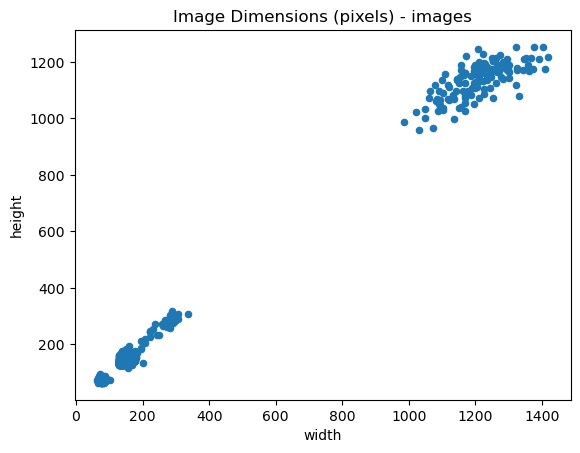

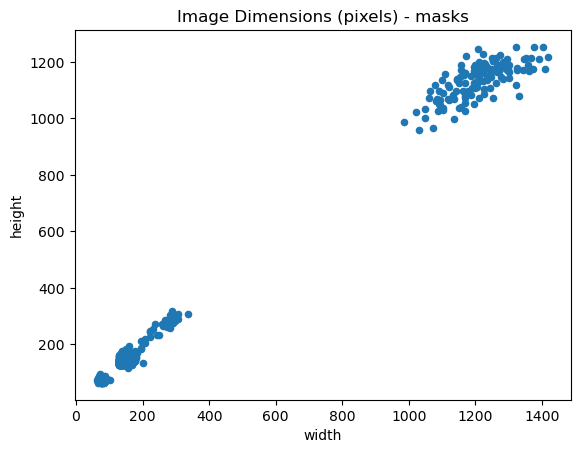

In [16]:
import os
import dask.bag as db
import numpy as np
import matplotlib.pyplot as plt

for label, directory in directories.items():
    filepath = directory
    filelist = [filepath + f for f in os.listdir(filepath)]
    if label == "images":
        dims = db.from_sequence(filelist).map(get_dimensions_images)
    elif label == "masks":
        dims = db.from_sequence(filelist).map(get_dimensions_masks)
        
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Dimensions (pixels) - {}'.format(label))

In [21]:
filepath = WSIROI_PATH + "images/"
filelist = [filepath + f for f in os.listdir(filepath)]

dims = db.from_sequence(filelist).map(get_dimensions_images)
dims = dims.compute()
dims


[(1253, 1323),
 (1180, 1295),
 (1190, 1300),
 (1180, 1212),
 (1166, 1224),
 (1137, 1144),
 (1178, 1214),
 (1138, 1146),
 (1151, 1186),
 (1162, 1170),
 (1150, 1234),
 (1173, 1156),
 (1181, 1235),
 (1201, 1290),
 (1199, 1293),
 (1179, 1261),
 (1176, 1298),
 (1184, 1275),
 (1189, 1158),
 (1219, 1419),
 (1208, 1259),
 (1215, 1351),
 (1252, 1404),
 (1213, 1368),
 (1173, 1245),
 (1146, 1246),
 (1083, 1134),
 (1214, 1262),
 (1213, 1249),
 (1170, 1324),
 (1193, 1229),
 (1190, 1200),
 (1203, 1252),
 (1151, 1208),
 (1244, 1208),
 (1204, 1254),
 (1163, 1266),
 (1172, 1343),
 (1165, 1300),
 (1168, 1199),
 (1181, 1196),
 (1158, 1213),
 (1196, 1291),
 (1165, 1246),
 (1220, 1172),
 (1179, 1223),
 (1252, 1375),
 (1190, 1281),
 (1183, 1224),
 (1147, 1155),
 (1156, 1110),
 (1161, 1169),
 (1174, 1248),
 (1175, 1274),
 (132, 129),
 (144, 141),
 (156, 152),
 (142, 136),
 (133, 134),
 (145, 140),
 (141, 138),
 (145, 152),
 (141, 151),
 (154, 148),
 (158, 151),
 (135, 133),
 (166, 136),
 (152, 150),
 (141, 1

In [26]:
aspect_ratios = []
for i in dims:
    aspect_ratios.append(i[1]/i[0])

df_aspect_ratios = pd.DataFrame(aspect_ratios)
df_aspect_ratios.head()

,0
0,1.055866
1,1.097458
2,1.092437
3,1.027119
4,1.049743


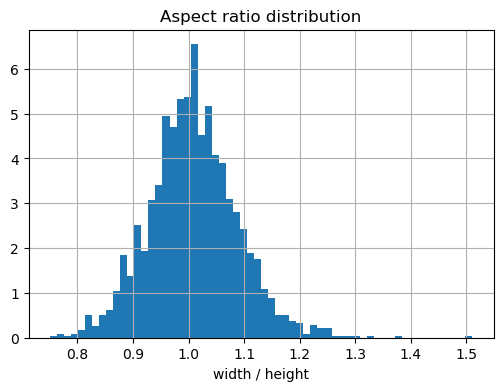

In [29]:
plt.figure(figsize=(6,4))
plt.hist(df_aspect_ratios, bins=60, density=True)
plt.xlabel("width / height")
plt.title("Aspect ratio distribution")
plt.grid(True)
plt.show()